# Stack multiple tiles of Sentinel-2 L2A data from Earth Search by Element 84 STAC API

This notebook shows an example how to stack multiple tiles of Sentinel-2 L2A data from Earth Search by Element 84 STAC API. The stacking is performed using [odc-stac](https://odc-stac.readthedocs.io/en/latest/), which allows to perform a mosaicking of multiple tiles measured on the same solar day, shown at the end of this notebook. 

### Setup
In order to run this notebook you need to install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac). You may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) directly from the git repository by cloning the repository, directing into `xcube-stac`, and following the steps below:

```bash
conda env create -f environment.yml
conda activate xcube-stac
pip install .
```

Note that [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) is a plugin of [`xcube`](https://xcube.readthedocs.io/en/latest/), where `xcube` is included in the `environment.yml`.  

Now, we first import everything we need:

In [1]:
%%time
from xcube.core.store import new_data_store

CPU times: user 2.79 s, sys: 242 ms, total: 3.03 s
Wall time: 1.87 s


First, we get the store parameters needed to initialize a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). We assign the url of the STAC catalog and set `stack_mode=True`.

In [2]:
%%time
store = new_data_store(
    "stac", url="https://earth-search.aws.element84.com/v1", stack_mode=True
)

CPU times: user 158 ms, sys: 36.3 ms, total: 195 ms
Wall time: 721 ms


In the stacking mode, the data IDs are the collection IDs within the STAC catalog. The data IDs can be listed using the following code.

In [3]:
%%time
store.list_data_ids()

CPU times: user 7.69 ms, sys: 311 µs, total: 8 ms
Wall time: 754 ms


['sentinel-2-pre-c1-l2a',
 'cop-dem-glo-30',
 'naip',
 'cop-dem-glo-90',
 'landsat-c2-l2',
 'sentinel-2-l2a',
 'sentinel-2-l1c',
 'sentinel-2-c1-l2a',
 'sentinel-1-grd']

Next, we open the data and assign `data_id` to `"sentinel-2-l2a"` to select Sentinel-2 L2A data. We set the bounding box to cover the greater Hamburg area and the time range to July 2020. Additionally, we need to set a query argument to select a specific [Sentinel-2 processing baseline](https://sentiwiki.copernicus.eu/web/s2-processing#S2Processing-L2Aprocessingbaseline), as the collection contains multiple items for the same tile with different processing procedures. Note that this requirement can vary between collections and must be specified by the user. To set query arguments, the STAC catalog needs to be conform with the [query extension](https://github.com/stac-api-extensions/query).

We can apply a reprojection by setting `crs` to the desired output projection. The odc-stac library uses [`rasterio.wrap.reproject`](https://rasterio.readthedocs.io/en/stable/topics/reproject.html) to handle the reprojection. All arguments of [odc.stac.load](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) can be passed into the `open_data(...)` method, which forwards them to the `odc.stac.load` function.

In [4]:
%%time
mlds = store.open_data(
    data_id="sentinel-2-l2a", 12.7 s
    bbox=[9.1, 53.1, 10.7, 54],
    time_range=["2020-07-01", "2020-08-01"],
    query={"s2:processing_baseline": {"eq": "02.14"}},
    crs="EPSG:4326",
    chunks={"time": 1, "x": 2048, "y": 2048},
)

CPU times: user 84.2 ms, sys: 33.5 ms, total: 118 ms
Wall time: 12.7 s


Since the tiles of the Sentinel-2 L2A in this STAC catalog are stored as cloud-optimized GeoTIFFs (COGs), a [xcube's multi-resolution  dataset](https://xcube.readthedocs.io/en/latest/mldatasets.html#xcube-multi-resolution-datasets) is created, where each level is linked to an overview level of the COG. The number of levels can be extracted as shown below. 

In [5]:
mlds.num_levels

4

To get a specific level, we use the `get_dataset(idx_level)` method. 

In [6]:
%%time
ds = mlds.get_dataset(2)
ds

CPU times: user 1.42 s, sys: 10.7 ms, total: 1.43 s
Wall time: 1.46 s


<xarray.Dataset> Size: 24GB
Dimensions:       (latitude: 897, longitude: 2191, time: 97)
Coordinates:
  * latitude      (latitude) float64 7kB 52.22 52.22 52.23 ... 54.14 54.15 54.15
  * longitude     (longitude) float64 18kB 7.469 7.471 7.473 ... 12.21 12.21
    spatial_ref   int32 4B 4326
  * time          (time) datetime64[ns] 776B 2020-07-01T10:46:00.261000 ... 2...
Data variables: (12/32)
    aot           (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    blue          (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    coastal       (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    green         (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    nir           (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    nir08         (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    ...            ...
    rededge3-jp2  (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    scl-jp2       (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    swir16-jp2    (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    swir22-jp2    (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    visual-jp2    (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    wvp-jp2       (time, latitude, longitude) float32 763MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>

We can plot a tile of the red band for a given timestamp as an example. Note that the bounding box encompasses all tiles within the dataset, so without mosaicking, many of the pixels will be NaN values.

CPU times: user 349 ms, sys: 95.3 ms, total: 444 ms
Wall time: 2.72 s


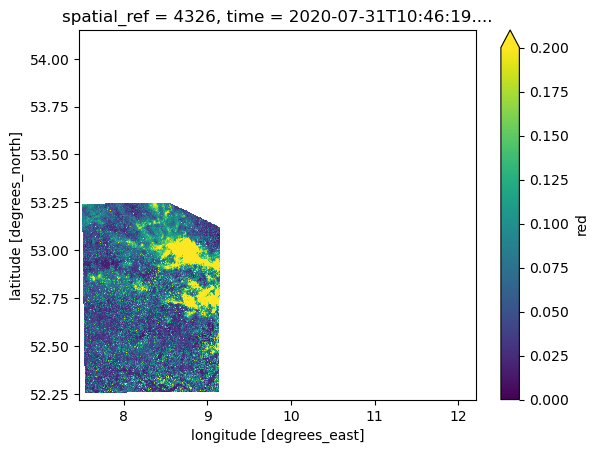

In [7]:
%%time
ds.red.isel(time=-1).plot(vmin=0, vmax=0.2)

To apply mosaicking, we need to assign `groupby="solar_day"`, as shown in the [documentation of `odc.stac.load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html).

In [8]:
%%time
mlds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=[9.1, 53.1, 10.7, 54],
    time_range=["2020-07-01", "2020-08-01"],
    query={"s2:processing_baseline": {"eq": "02.14"}},
    crs="EPSG:4326",
    chunks={"time": 1, "x": 2048, "y": 2048},
    groupby="solar_day",
)

CPU times: user 189 ms, sys: 15.3 ms, total: 204 ms
Wall time: 10.4 s


We again select the desired level and plot the same example as before. 

In [9]:
%%time
ds = mlds.get_dataset(2)
ds

CPU times: user 1.34 s, sys: 3.63 ms, total: 1.35 s
Wall time: 1.34 s


<xarray.Dataset> Size: 5GB
Dimensions:       (latitude: 897, longitude: 2191, time: 19)
Coordinates:
  * latitude      (latitude) float64 7kB 52.22 52.22 52.23 ... 54.14 54.15 54.15
  * longitude     (longitude) float64 18kB 7.469 7.471 7.473 ... 12.21 12.21
    spatial_ref   int32 4B 4326
  * time          (time) datetime64[ns] 152B 2020-07-01T10:46:00.261000 ... 2...
Data variables: (12/32)
    aot           (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    blue          (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    coastal       (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    green         (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    nir           (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    nir08         (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    ...            ...
    rededge3-jp2  (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    scl-jp2       (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    swir16-jp2    (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    swir22-jp2    (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    visual-jp2    (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>
    wvp-jp2       (time, latitude, longitude) float32 149MB dask.array<chunksize=(1, 897, 2048), meta=np.ndarray>

CPU times: user 384 ms, sys: 71.7 ms, total: 455 ms
Wall time: 12.2 s


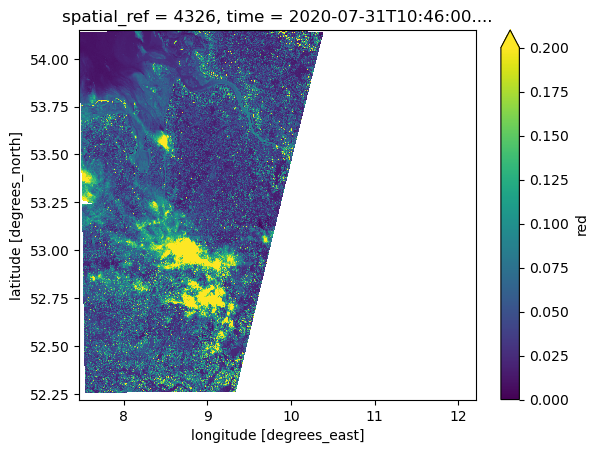

In [10]:
%%time
ds.red.isel(time=-1).plot(vmin=0, vmax=0.2)